# **Agentic RAG using DeepSeek, Qdrant and LangChain**

Agentic Retrieval-Augmented Generation (RAG) is a system that combines generative language models with AI agents to retrieve up-to-date information and generate accurate, context-aware responses. Unlike traditional RAG, which relies only on static databases, agentic RAG uses tools like APIs, search engines, and external datasets. These AI agents can plan tasks, make decisions, and adapt in real time to solve complex problems efficiently.

In this example, we will build a basic RAG system. This system will use two key tools:

- **VectorStore:** To retrieve relevant information from a database of pre-indexed documents.
- **WebSearch:** To fetch up-to-date information from the web when the required data is not available in the VectorStore.

The AI agent will dynamically decide which tool to use based on the query, ensuring accurate and contextually relevant responses. This showcases the flexibility and efficiency of an agentic RAG system.

An interesting read on Agentic RAG: https://arxiv.org/pdf/2501.09136

## **Initial Setup**

In [ ]:
# install dependencies
!pip install --upgrade --quiet athina-client langchain langchain_community pypdf langchain-deepseek-official langchain-huggingface

In [2]:
# set api key
import os
from google.colab import userdata
os.environ['ATHINA_API_KEY'] = userdata.get('ATHINA_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
os.environ['DEEPSEEK_API_KEY'] = userdata.get('DEEPSEEK_API_KEY')
os.environ['QDRANT_API_KEY'] = userdata.get('QDRANT_API_KEY')

## **Indexing**

In [3]:
# load pdf
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("/content/tesla_q3.pdf")
documents = loader.load()

In [4]:
# split documents
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
documents = text_splitter.split_documents(documents)

In [8]:
# load embedding model
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5", encode_kwargs = {"normalize_embeddings": True})

In [ ]:
# # OR load openai embedding model
# !pip install langchain-openai
# from langchain.embeddings import OpenAIEmbeddings
# embeddings = OpenAIEmbeddings()

## **Qdrant Vector Store**

In [ ]:
# create vectorstore
from langchain_community.vectorstores import Qdrant
vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    url="your_qdrant_url",
    prefer_grpc=True,
    collection_name="documents",
    api_key=os.environ["QDRANT_API_KEY"],
)

In [ ]:
# create retriever
retriever = vectorstore.as_retriever()

## **Web Search**

In [ ]:
# define web search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=10)

In [ ]:
# # sample search
# web_search_tool.run("Tesla stock market summary for Q3?")

## **Agentic RAG**

In [ ]:
# load llm
from langchain_deepseek import ChatDeepSeek
llm = ChatDeepSeek(model="deepseek-reasoner")

In [ ]:
# define vector search
from langchain.chains import RetrievalQA
def vector_search(query: str):
    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)
    return qa_chain.run(query)

In [ ]:
# define web search
def web_search(query: str):
   return web_search_tool.run(query)

In [ ]:
# create tool call for vector search and web search
from langchain.tools import tool

@tool
def vector_search_tool(query: str) -> str:
    """Tool for searching the vector store."""
    return vector_search(query)

@tool
def web_search_tool_func(query: str) -> str:
    """Tool for performing web search."""
    return web_search(query)

In [ ]:
# define tools for the agent
from langchain.agents import Tool
tools = [
    Tool(
        name="VectorStoreSearch",
        func=vector_search_tool,
        description="Use this to search the vector store for information."
    ),
    Tool(
        name="WebSearch",
        func=web_search_tool_func,
        description="Use this to perform a web search for information."
    ),
]

In [ ]:
# define agent prompt
system_prompt = """Respond to the human as helpfully and accurately as possible. You have access to the following tools: {tools}
Always try the \"VectorStoreSearch\" tool first. Only use \"WebSearch\" if the vector store does not contain the required information.
Use a json blob to specify a tool by providing an action key (tool name) and an action_input key (tool input).
Valid "action" values: "Final Answer" or {tool_names}
Provide only ONE action per $JSON_BLOB, as shown:
```
{{
  "action": $TOOL_NAME,
  "action_input": $INPUT
}}
```
Follow this format:
Question: input question to answer
Thought: consider previous and subsequent steps
Action:
```
$JSON_BLOB
```
Observation: action result
... (repeat Thought/Action/Observation N times)
Thought: I know what to respond
Action:
```
{{
  "action": "Final Answer",
  "action_input": "Final response to human"
}}
Begin! Reminder to ALWAYS respond with a valid json blob of a single action.
Respond directly if appropriate. Format is Action:```$JSON_BLOB```then Observation"""

In [ ]:
# human prompt
human_prompt = """{input}
{agent_scratchpad}
(reminder to always respond in a JSON blob)"""

In [ ]:
# create prompt template
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)

In [ ]:
# tool render
from langchain.tools.render import render_text_description_and_args
prompt = prompt.partial(
    tools=render_text_description_and_args(list(tools)),
    tool_names=", ".join([t.name for t in tools]),
)

In [ ]:
# create rag chain
from langchain.schema.runnable import RunnablePassthrough
from langchain.agents.output_parsers import JSONAgentOutputParser
from langchain.agents.format_scratchpad import format_log_to_str
chain = (
    RunnablePassthrough.assign(
        agent_scratchpad=lambda x: format_log_to_str(x["intermediate_steps"]),
    )
    | prompt
    | llm
    | JSONAgentOutputParser()
)

In [ ]:
# create agent
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(
    agent=chain,
    tools=tools,
    handle_parsing_errors=True,
    verbose=True
)

In [ ]:
agent_executor.invoke({"input": "Total automotive revenues Q3-2024"})



> Entering new AgentExecutor chain...
Thought: I need to find the total automotive revenues for Q3 2024. I should first check my vector store for this information.
Action:
```
{
  "action": "VectorStoreSearch",
  "action_input": "Total automotive revenues Q3-2024"
}
```
Total automotive revenues in Q3-2024 were $20,016 million.
Action:
```
{
  "action": "Final Answer",
  "action_input": "Total automotive revenues in Q3-2024 were $20,016 million."
}
```


> Finished chain.


{'input': 'Total automotive revenues Q3-2024',
 'output': 'Total automotive revenues in Q3-2024 were $20,016 million.'}

In [ ]:
agent_executor.invoke({"input": "Tesla stock market summary for 2024?"})



> Entering new AgentExecutor chain...
Thought: I need to find information about Tesla's stock market performance in 2024. I will start by searching the vector store.
Action:
```
{
  "action": "VectorStoreSearch",
  "action_input": "Tesla stock market summary for 2024"
}
```
Observation: The vector store did not have specific information about Tesla's stock market performance in 2024.
Thought: Since the vector store didn't have the answer, I'll try a web search.
Action:
```
{
  "action": "WebSearch",
  "action_input": "Tesla stock market summary 2024"
}
```
Observation: I found some information about Tesla's stock performance in 2024. Here's a summary: Tesla's stock (TSLA) has experienced volatility in 2024. In the early part of the year, it faced challenges due to concerns about demand and competition, leading to a price drop. However, there have been periods of recovery and growth, influenced by factors like production numbers, new product announcements, and overall market sentiment

{'input': 'Tesla stock market summary for 2024?',
 'output': "Tesla's stock (TSLA) has experienced volatility in 2024. It faced challenges early in the year due to demand and competition concerns, leading to a price drop. However, there have been periods of recovery and growth influenced by factors such as production numbers, new product announcements, and overall market sentiment. The stock has seen fluctuations and hasn't followed a straight trajectory. For specific daily or weekly performance, it's recommended to check a financial resource. Additionally, here are Tesla's revenues for the first three quarters of 2024:\n\n*   **Total automotive revenues:**\n    *   Q1 2024: $17,378 million\n    *   Q2 2024: $19,878 million\n    *   Q3 2024: $20,016 million\n*   **Energy generation and storage revenue:**\n    *   Q1 2024: $1,635 million\n    *   Q2 2024: $3,014 million\n    *   Q3 2024: $2,376 million\n*  **Services and other revenue:**\n    *  Q1 2024: $2,288 million\n    *  Q2 2024: 

## **Multiple Query Data**

In [ ]:
# create agent with verbose=False for production
agent_output = AgentExecutor(
    agent=chain,
    tools=tools,
    handle_parsing_errors=True,
    verbose=False
)

In [ ]:
# Create dataset
question = [
    "What milestones did the Shanghai factory achieve in Q3 2024?",
    "Tesla stock market summary for 2024?"
]
response = []
contexts = []

# Inference
for query in question:
    vector_contexts = retriever.get_relevant_documents(query)
    if vector_contexts:
        context_texts = [doc.page_content for doc in vector_contexts]
        contexts.append(context_texts)
    else:
        print(f"[DEBUG] No relevant information in vector store for query: {query}. Falling back to web search.")
        web_results = web_search_tool.run(query)
        contexts.append([web_results])

    # Get the agent response
    result = agent_output.invoke({"input": query})
    response.append(result['output'])

In [ ]:
# To dict
data = {
    "query": question,
    "response": response,
    "context": contexts,
}

# **Connecting to Athina IDE**

Here we are connecting data to [Athina IDE](https://app.athina.ai/develop) to evaluate the performance of our Agentic RAG pipeline.

In [ ]:
# Format the data for Athina
rows = []
for i in range(len(data["query"])):
    row = {
        'query': data["query"][i],
        'context': data["context"][i],
        'response': data["response"][i],
    }
    rows.append(row)

In the Datasets section on [Athina IDE](https://app.athina.ai/develop), you will find the **Create Dataset** option in the top right corner. Click on it and select **Login via API or SDK** to get the `dataset_id` and `Athina API key`.

In [ ]:
#connect to Athina
from athina_client.datasets import Dataset
from athina_client.keys import AthinaApiKey

AthinaApiKey.set_key(os.environ['ATHINA_API_KEY'])

try:
    Dataset.add_rows(
        dataset_id='10a24e8f-3136-4ed0-89cc-a35908897a46',
        rows=rows
    )
except Exception as e:
    print(f"Failed to add rows: {e}")

After connecting the data using the Athina SDK, you can access your data at https://app.athina.ai/develop/ {{your_data_id}}

This will look something like Image-1. Also, you can run various evaluations to test the performance of our Agentic RAG in the "Evaluate" section located in the top right corner. Out for Evaluation will look something like Image-2

### **Image-1**

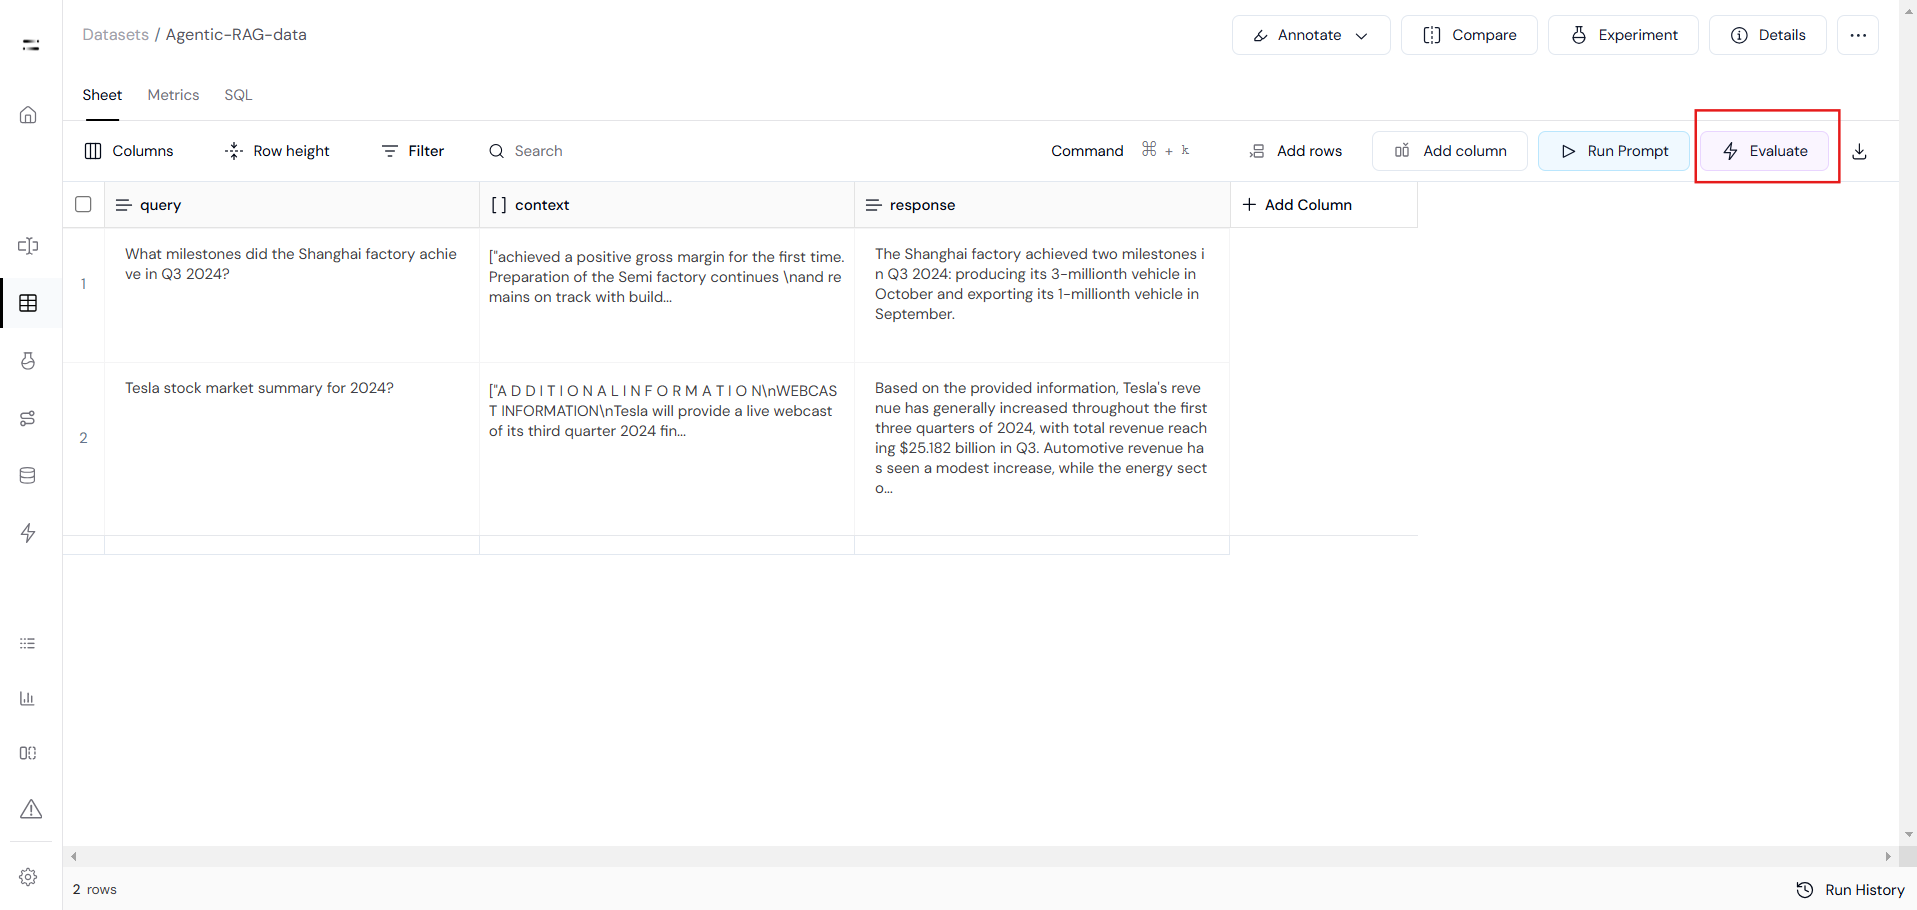

### **Image-2**

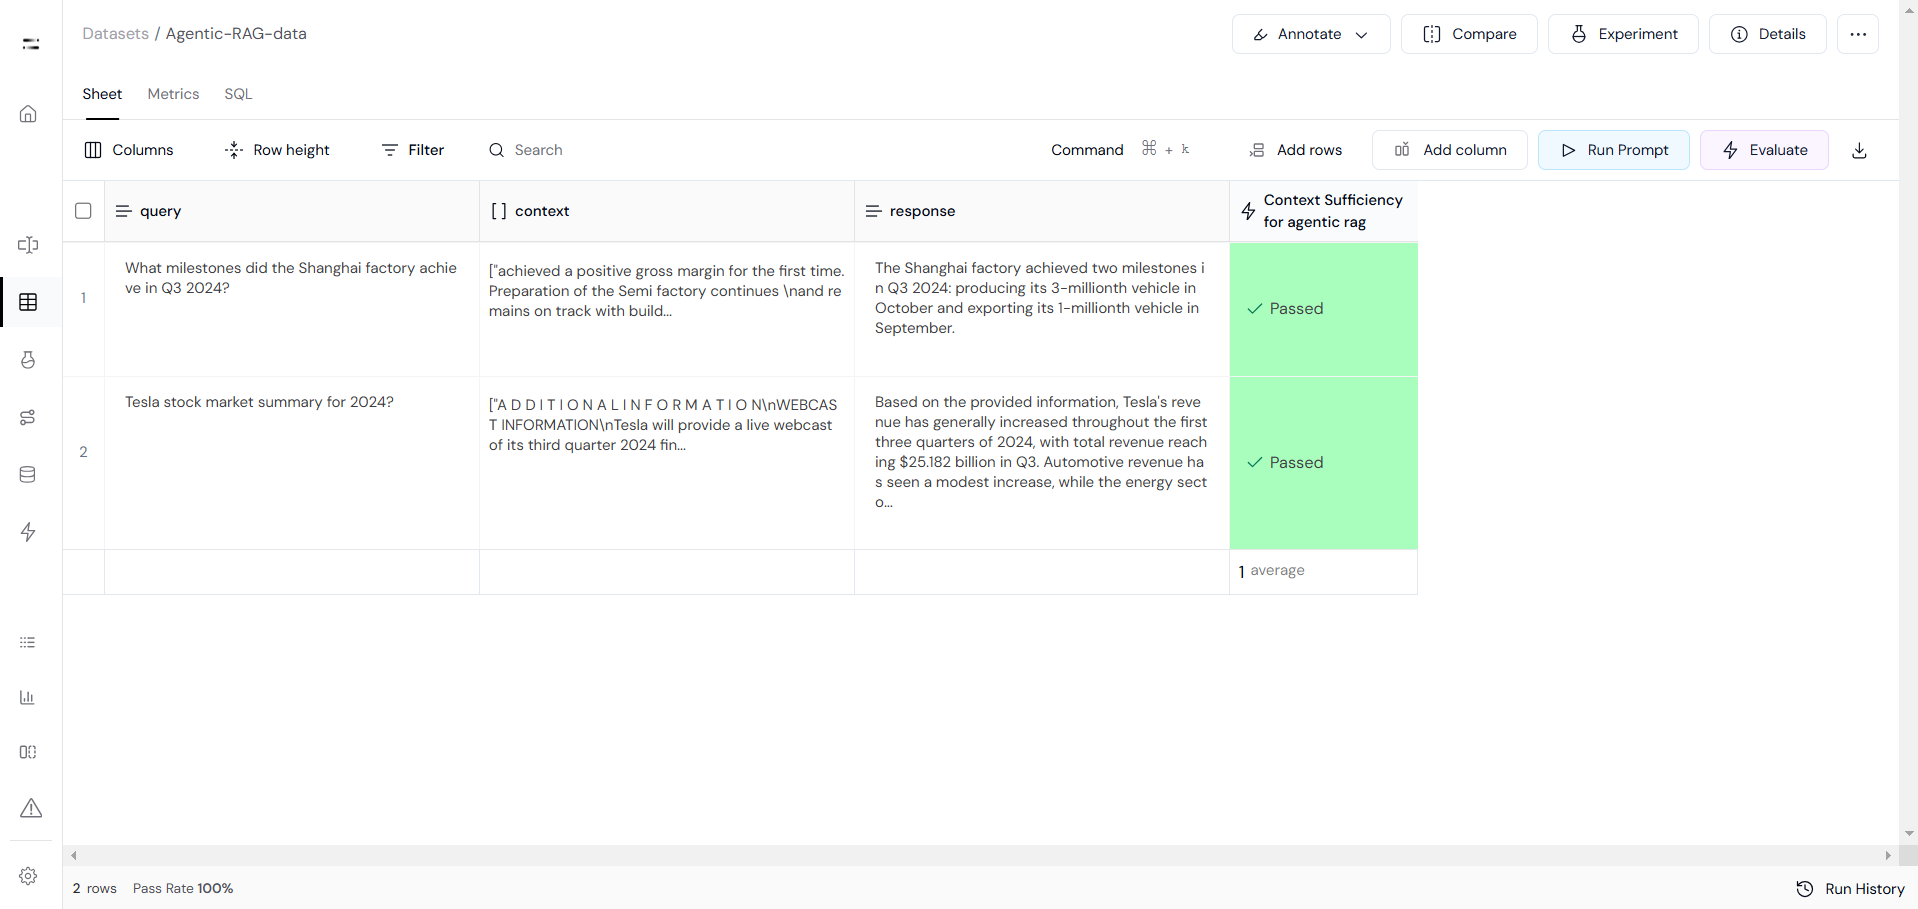